#  Discontinuity

Determine whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("banking.csv")
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


* Level 0: Expected recovery amounts 0-1000
* Level 1: Expected recovery amounts >1000
* Threshold: 1000 

## Exploratory data analysis

Text(0, 0.5, 'age')

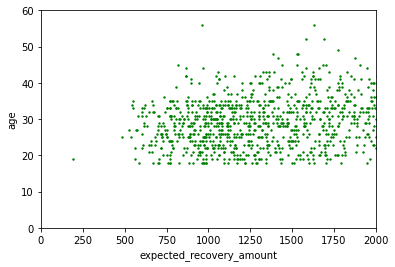

In [2]:

from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel('expected_recovery_amount')
plt.ylabel('age')


## Kruskal-Wallis test: Do ages make any difference?

In [3]:

from scipy import stats
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age,Level_1_age) 

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

## Chi-square: Does customer gender matter?

In [4]:
# Chi-square tests on Customer gender
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) & 
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'], 
                       df['sex'])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

0.5377947810444592


 Customers around $1000 threshold are similar in  age and gender

## Recovery amount

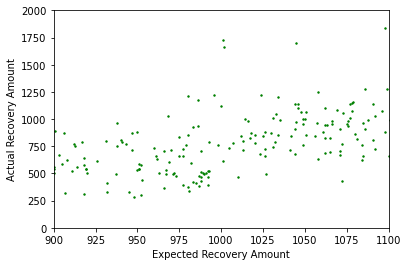

In [9]:
# Actual Recovery Amount vs. Expected Recovery Amount 
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.show()

In [10]:
# statistical tests 
#Check if the actual recovery amount has a discontinuity around 1000 threshold.
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual,Level_1_actual))

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)


In [12]:
# Repeat for a smaller range of $950 to $1050
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = era_950_1050.loc[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']
print(stats.kruskal(Level_0_actual,Level_1_actual))

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)


## Regression modeling

In [14]:
# Regression modeling: With threshold
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

X = era_900_1100[['expected_recovery_amount','indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Sun, 13 Sep 2020   Prob (F-statistic):           1.83e-15
Time:                            17:13:34   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

## Regression modeling: adjusting the window

In [15]:
# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Sun, 13 Sep 2020   Prob (F-statistic):           1.12e-07
Time:                            17:14:08   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Conclusion: the higher recovery strategy is worth the extra cost of $50 per customer.